# TD 4 - Topological Persistence


*by Joseph DE ROFFIGNAC and Ten NGUYEN HANAOKA* 

The purpose of this notebook is to address all the exercises from Lab Session 4 (INF556 – TD4), which focuses on implementing an algorithm to compute persistent homology with coefficients in the field ℤ/2ℤ (also denoted ℤ₂), and on testing it across various filtrations.

### Let's start with some imports !

In [1]:
%pip install tqdm
%pip install plotly

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import read_filtration, plot_barcodes

We are provided with a Simplex class (see simplex.py for more details) that contains three attributes:
* val (float): the time of appearance in the filtration,
* dim (int): the dimension,
* vert (list[int]): the list of vertex IDs (integers).

In addition, a read_filtration function in utils.py is available, which takes a filename (str) as input and returns a filtration represented as a list of simplices.

An example of how to use read_filtration is given just below :

In [3]:
filtration = read_filtration("filtrations/filtration_test.txt")
for simplex in filtration:
    print(simplex)
type(filtration[0])

{'time': 1.0, 'dim': 0, 'vert': {2}}
{'time': 1.0, 'dim': 0, 'vert': {4}}
{'time': 1.0, 'dim': 0, 'vert': {1}}
{'time': 2.0, 'dim': 1, 'vert': {2, 4}}
{'time': 2.0, 'dim': 1, 'vert': {1, 2}}
{'time': 3.0, 'dim': 0, 'vert': {7}}
{'time': 4.0, 'dim': 1, 'vert': {4, 7}}
{'time': 4.0, 'dim': 1, 'vert': {1, 7}}
{'time': 5.0, 'dim': 1, 'vert': {1, 4}}
{'time': 6.0, 'dim': 2, 'vert': {1, 4, 7}}


dict

To simplify our process, we've added a line in read_filtration, that outputs a time sorted filtration

## Question 1 - Boundary matrix

**Question 1**:Compute the boundary matrix B of the filtration from the vector of simplices F. 

Nous avons opté pour une représentation sparse de la boundary matrix : une liste de sets python indexée par les colonnes de la matrice (j). Formellement :

$$\forall j\in [\![0, m-1]\!],  B[j] = \{i \in [\![0, m-1]\!], b_{i,j} = 1\}$$

où $(b_{i,j}) \in \mathcal{M}_m(\mathbb{Z}_2)$ is the boundary matrix.\
\
\
Les avantages sont les suivants :
- La complexité en mémoire est linéaire en le nombre de 1 de b, qui sera souvent en pratique en O(m) ou o(m^2)
- L'utilisation de sets python permet de faire efficacement des différences symétriques entre colonnes, lors de l'algorithme de réduction de matrice (cf. Q2)

In [4]:
def boundary_matrix(filtration: list[dict]) -> list[set[int]]:
    
    # Dictionnaire : clé = frozenset(vertices), valeur = index dans la filtration
    index_map = {frozenset(s["vert"]): i for i, s in enumerate(filtration)}

    n = len(filtration)
    boundary = [set() for _ in range(n)]

    for j, simplex in enumerate(filtration):
        verts = simplex["vert"]
        dim = simplex["dim"]

        # Génération des faces en retirant un sommet
        if dim > 0:
            for v in verts:
                face = frozenset(verts - {v})
                i = index_map.get(face)
                if i is not None:
                    boundary[j].add(i)

    return boundary

print(boundary_matrix(filtration))

[set(), set(), set(), {0, 1}, {0, 2}, set(), {1, 5}, {2, 5}, {1, 2}, {8, 6, 7}]


Pour créer la boundary matrix, on pourrait itérer sur i et j entre 1 et m, et tester si \sigma_i est une face de \sigma_j, mais la complexité serait beaucoup trop élevée avec cette algorithme naif : \Omega(m^2).

Cependant, étant donné un simplex $\sigma_j = [v_0, \dots, v_r]$, il y a en réalité peu de simplexes \sigma_i qui pourrait en être une face : ce sont simplement les $[v_0, \dots, \hat{v_i}, \dots v_r]$. 
Par conséquent, il suffit de stocker les simplexes, index dans un dictionnaire index_map = {vertices -> index} (en utilisant le type immutable frozenset).

Pour chaque simplexe $\sigma_j$, on récupère simplement les index i de ces faces (qui sont nécessairement dans la filtration puis qu'on a un simpplexe simpliciel).

Pour ce qui est de la complexité :
- L4 : création du dictionnaire d'index en O(m)
- L9 : parcours des $m$ simplexes
    - Pour chaque simplexe $\sigma$, la complexité temporelle est en $O(dim(\sigma))$ (L15)
        Si la dimension des simplexes est bornée (en pratique dans ce TD on ne dépasse pas la dimension 3), chaque simplexe est traité en temps constant.
    - Dans le cas où les dimensions $d$ des simplexes peuvent être arbitrairement grandes, notons tout de même qu'un simplexe de dimension $d$ est toujours accompagné de ces $2^d - 1$ parties. On en déduit que d_{max} = O(log(m))

Conclusion : La complexité de boundary_matrix est linéaire dans ce TD (et quasi-linéaire très peu de cas : par exemple pour les boules \mathbb{B}_d et sphères \mathbb{S}_d ) 

## Questions 2 & 3 - Reduction algorithm

**Question 2**  : Implement the reduction algorithm for your representation of the boundary matrix. Evaluate its complexity.

In [5]:
def reduce_boundary_matrix(boundary : list[set[int]]) -> list[set[int]]:
    
    reduced_boundary = boundary.copy()
    m = len(reduced_boundary)

    pivots = {}

    for j in range(m):

        low_j = max(reduced_boundary[j]) if reduced_boundary[j] else -1
        while low_j != -1 and low_j in pivots:

            i = pivots[low_j]

            # Perform column addition (mod 2) : XOR
            reduced_boundary[j] = set(reduced_boundary[j]) ^ set(reduced_boundary[i])
            low_j = max(reduced_boundary[j]) if reduced_boundary[j] else -1
        if low_j != -1:
            pivots[low_j] = j

    return reduced_boundary


**Question 3** Reduce the complexity of the reduction to O(m^3) in the worst case, and to O(m) in cases where the matrix remains sparse throughout, where m is the number of simplices in the filtration. Argue that your code does have the desired worst-case and best-case complexities.

É

## Question 4 - Barcode extraction

**Question 4** Write a function that outputs the barcode from the reduced boundary matrix in a file. The format must be the following one: 1 line per interval, containing 3 numbers: the dimension of the homological feature associated with the interval, the left endpoint of the interval (which is the filtration value associated with the simplex that created the homological feature), the right endpoint (which is the filtration value associated with the simplex that killed the homological feature), separated by white spaces. For instance, interval [b,d) in dimension k is written k b d.

For this part, we've implemented step by step the algorithm given in the end of lecture 4.

In [6]:
def extract_barcodes(reduced_boundary: list[set[int]], filtration: list[dict]) -> list[tuple[int, int, int]]:
    barcodes = []
    paired = set()

    for j, col in enumerate(reduced_boundary):
        if col:
            low_j = max(col)  # sorted list: last element = pivot 
            barcodes.append((filtration[low_j]["dim"], low_j, j))  # (dimension, birth, death)
            paired.add(low_j)
            paired.add(j)

    # Infinite bars: unpaired simplices
    for i, f in enumerate(filtration):
        if i not in paired:
            barcodes.append((f["dim"], i, -1))  # death = ∞

    # Sort by (dimension, birth index, death index)
    barcodes.sort(key=lambda x: (x[0], x[1], x[2] if x[2] != -1 else float('inf')))

    # Convert bars to (dimension, birth time, death time)
    barcodes = [(dim, filtration[birth_idx]["time"], filtration[death_idx]["time"] if death_idx != -1 else float('inf'))
                for dim, birth_idx, death_idx in barcodes]
    return barcodes


Here the time complexity of the function is 

In [7]:
def print_barcodes(barcodes: list[tuple[int, int, int]]) -> None:
    for dim, birth, death in barcodes:
        print(f"Dimension: {dim}, Birth: {birth}, Death: {death}")

## Question 5 - Complexity analysis

In [8]:
def process_filtration(filtration: list[dict], name: str) -> float:
    # Returns the time in seconds taken to process the filtration
    start_time = time.time()
    B = boundary_matrix(filtration)
    print("Boundary matrix computed.")
    barcodes = extract_barcodes(reduce_boundary_matrix(B), filtration)
    print("Barcodes extracted.")
    end_time = time.time()
    plot_barcodes(barcodes, name=name)
    return end_time - start_time

## TODO list


In [9]:
# TODO : report, answer questions, complexity analysis, plots, analysis of graphs, 2 3 pages. 
# >>> jupyter notebook
# + représentation graphique + tableau des temps

## Question 5 - 6

Dans toutes les filtrations que nous proposons, le filtration value de chaque simplexe sera égale à sa dimension. Il est clair que cela définit bien un ordre topologique sur la filtration. Par exemple les sommets seront insérés au temps 0.0, les arêtes au temps 1.0, etc. 

Cela améliora la lecture des barcodes puisqu'il y aura en pratique très peu de timestamp et donc de bar distinctes.

Par conséquent, on se contente seulement de définir la triangulation des objets étudiés.

### $\mathbb{B}_d$ and $\mathbb{S}_d$

Pour les boules et les sphères en dimension $d$, la filtration est plutôt directe : 
- Pour une boule en dimension d, on considère des sommets $0,...,d$, puis on pose $K := \mathcal{P}([\![0,d]\!]) \\ \{\emptyset\}$, l'ensemble des parties non-vides de $[\![0,d]\!]$
- Pour une sphère en dimension $d$, on prend la filtration de $\mathbb{B}_{d+1}$ où l'on enlève le simplexe de dimension $d+1$.

Boundary matrix computed.
Barcodes extracted.


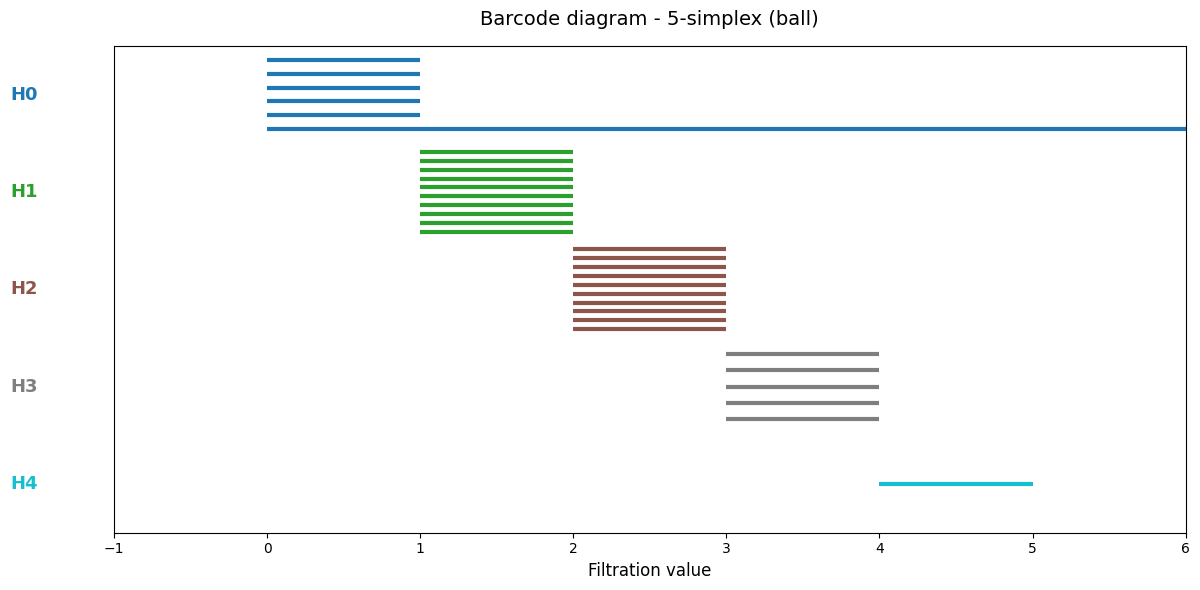

Boundary matrix computed.
Barcodes extracted.


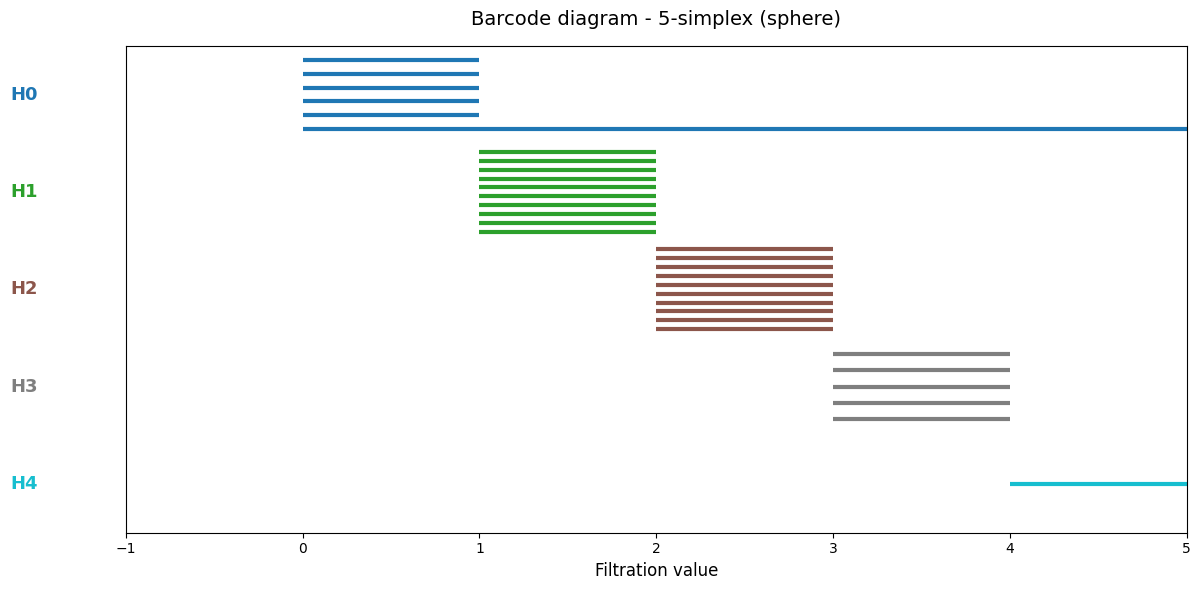

0.0003161430358886719

In [10]:
from itertools import combinations

def create_filtration(shape = "ball", dim = 10):
    # énumérer les parties d'une liste de points
    if shape == "ball":
        points = list(range(dim + 1))
    elif shape == "sphere":
        points = list(range(dim + 2))
    else:
        raise Exception("Shape should be \"ball\" or \"sphere\"")

    filtration = []
    for r in range(dim+1):
        for comb in combinations(points, r+1):
            filtration.append({"vert": set(comb), "dim": r, "time": r})

    return filtration

process_filtration(create_filtration("ball", 5), name="5-simplex (ball)")
process_filtration(create_filtration("sphere", 4), name="5-simplex (sphere)")

On retrouve le résultat du cours et des exercices : 
Pour la boule $B_d$, on a \beta_0 = 1 et \beta_r = 0 pour r \geqslant 1.
Pour la sphère $S_d$, on a \beta_0 = \beta_d = 1 et \beta_r = 0 sinon.

Notons que les barres du code barre s'organisent en blocs de barres $[d, d+1)$, auquel on ajoute les barres infinies $[d, +\infty)$. Cela est dû qu fait que les seuls simplexes pouvant créer ou tuer une barre en dimension d sont au temps d+1.

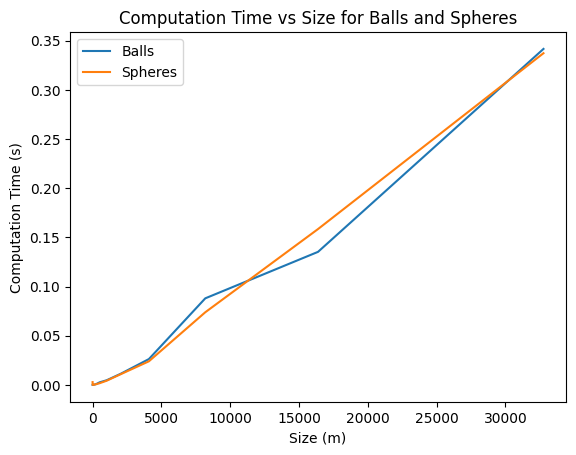

In [11]:
# Tracé le temps de calcul en fonction de la dimension pour les deux types de filtrations
max_dim = 15

ball_sizes = [2**(d+1) - 1 for d in range(0, max_dim)]
sphere_sizes = [2**(d+2) - 2 for d in range(0, max_dim-1)]
ball_times = []
sphere_times = []
for dim in range(0, max_dim):
    start_time = time.time()
    _ = reduce_boundary_matrix(boundary_matrix(create_filtration("ball", dim)))
    ball_time = time.time() - start_time
    ball_times.append(ball_time)
for dim in range(0, max_dim-1):
    start_time = time.time()
    _ = reduce_boundary_matrix(boundary_matrix(create_filtration("sphere", dim)))
    sphere_time = time.time() - start_time
    sphere_times.append(sphere_time)

plt.plot(ball_sizes, ball_times, label="Balls")
plt.plot(sphere_sizes, sphere_times, label="Spheres")
plt.xlabel("Size (m)")
plt.ylabel("Computation Time (s)")
plt.title("Computation Time vs Size for Balls and Spheres")
plt.legend()
plt.show()

On remarque que le temps de calcul pour les sphères et les boules est pratiquement linéaire en fonction de la taille de la filtration.
Cela corrobore le résultat de la question 3. Notons que la matrice contient O(m) éléments non nuls dans le cas des boules (et aussi des sphères).

En effet, pour une boule de dimension d et pour k \in [\![1, d]\!], la filtration contient \binom{d+1}{k+1} simplices de dimension k, et chaque simplex de dimension k a k+1 faces de dimension k-1. Ainsi, le nombre total d'éléments non nuls dans la matrice des frontières est :
$\sum_{k=1}^{d} (k+1) \binom{d+1}{k+1} = (d+2) 2^{d} - (d+1) = O(m)$.

### Moebius band

<p align="center">
    <img src="img/triangulation_moebius_band.png" alt="Moebius band triangulation" width="300", center />
</p>

On peut utiliser une triangulation similaire à celle du cylindre en utilisant 6 sommets, 12 arêtes, 6 triangles, comme représentée ci-dessus.

### Torus

<p align="center">
    <img src="img/triangulation_torus.png" alt="Torus triangulation" width="300", center />
</p>

La triangulation utilisée est similaire à celle vue lors des exercices. À cause du recollement des bords haut et bas, on est forcé d'ajouter 3 nouveaux sommets. On a maintenant 9 sommets, 27 arêtes et 18 triangles.

Boundary matrix computed.
Barcodes extracted.


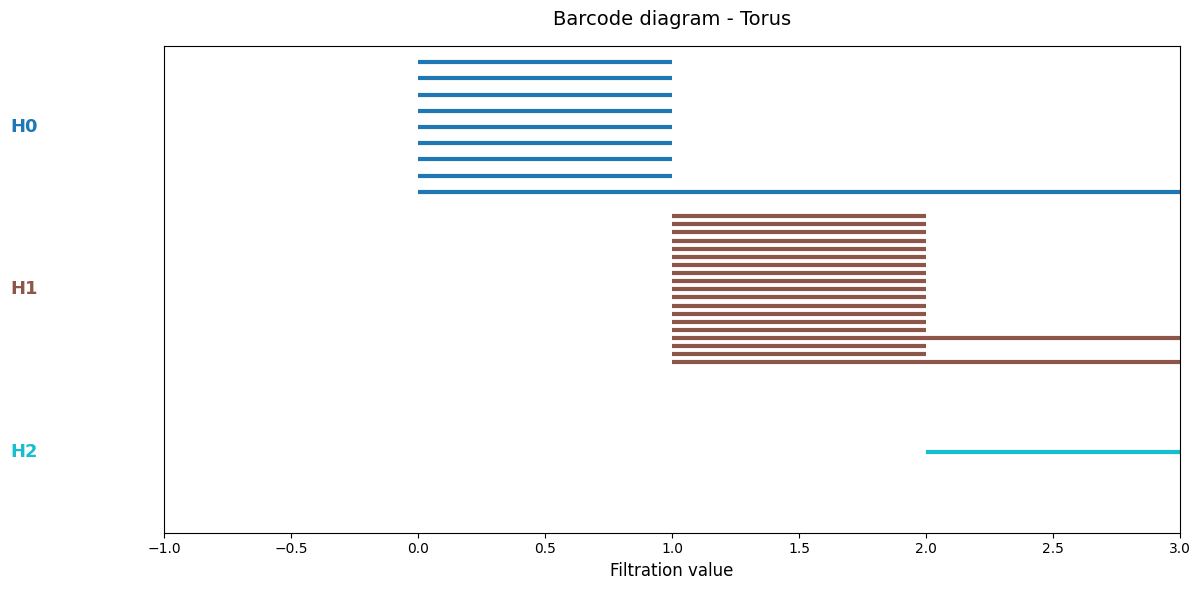

0.0001327991485595703

In [12]:
filtration = read_filtration("filtrations/filtration_torus.txt")
process_filtration(filtration, name="Torus")

### Klein bottle

<p align="center">
    <img src="img/triangulation_klein_bottle.png" alt="Klein bottle triangulation" width="300", center />
</p>

On reprend la même triangulation que pour le torus, mais on inverse la représentation des sommets 3 et 4 sur le bord droit.


---

### Projective plane $\mathbb{RP}^2$

<p align="center">
    <img src="img/triangulation_projective_plane.png" alt="Projective plane triangulation" width="300", center />
</p>

Boundary matrix computed.
Barcodes extracted.


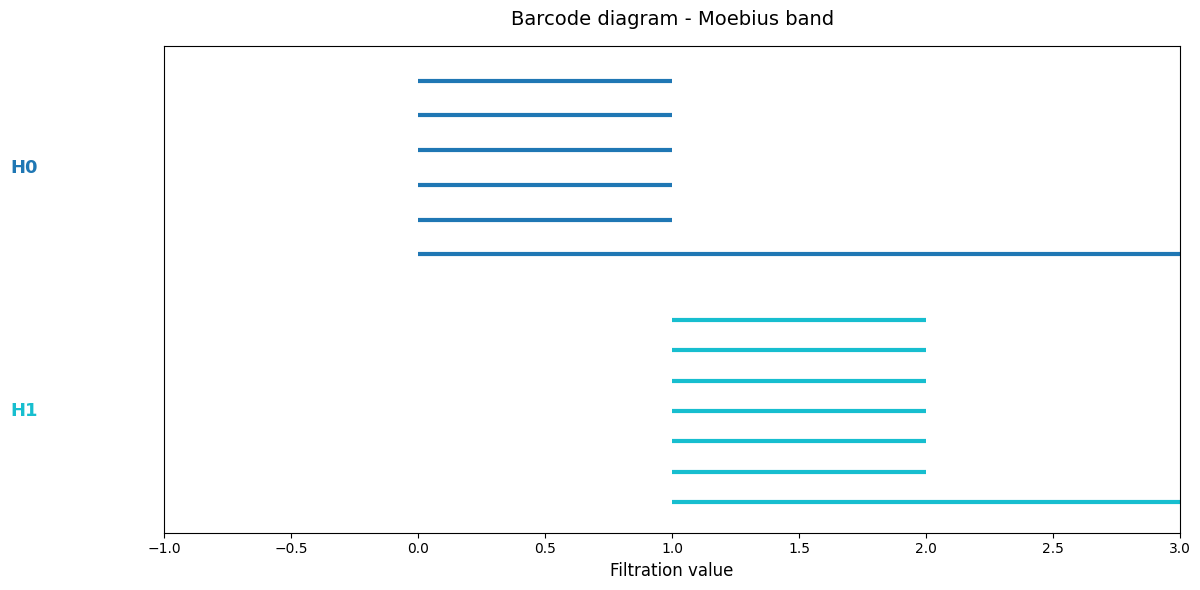

In [13]:
filtration = read_filtration("filtrations/filtration_moebius.txt")
_ = process_filtration(filtration, name="Moebius band")

## 3.2. Simulated data

### Filtration A

In [14]:
filtration_a = read_filtration("filtrations/filtration_A.txt")
duration = process_filtration(filtration_a, name="Filtration A")
print("Size of filtration A:", len(filtration_a))
print("Time to process filtration A:", duration, "seconds")

Boundary matrix computed.


KeyboardInterrupt: 

Size of filtration A : 428643
Time to process filtration A: 108.70776009559631 seconds

Analyse de l'objet topologique sous-jacent :

- D'après le diagramme du barcode, on mesure \beta_0 = 1, \beta_1 = 0, \beta_2 = 0, etc.... Ainsi, l'objet topologique correspondant est connexe, sans trous, ni cavité, .... Toutes les variétés connexes parties de cet objet sont homotopes à un point.
- On peut également étudier la construction dynamique de la filtration. Au début, tous les sommets sont générés de manière individuelle (c'est là que naissent la plupart des barres de H_0). Ensuite les arêtes sont progressivement rajoutées, ce qui supprime de nombreuses composantes connexes (les points se rejoignent, les barres de H_0 meurent). Enfin, quelques triangles (simplexes 2D) viennent éliminer tous les nombreux 1-cycles créés, sans créer de cavité.
Conclusion : Globalement, les simplexes sont rajoutés dans l'ordre de leur dimension.

### Filtration B

Boundary matrix computed.
Barcodes extracted.


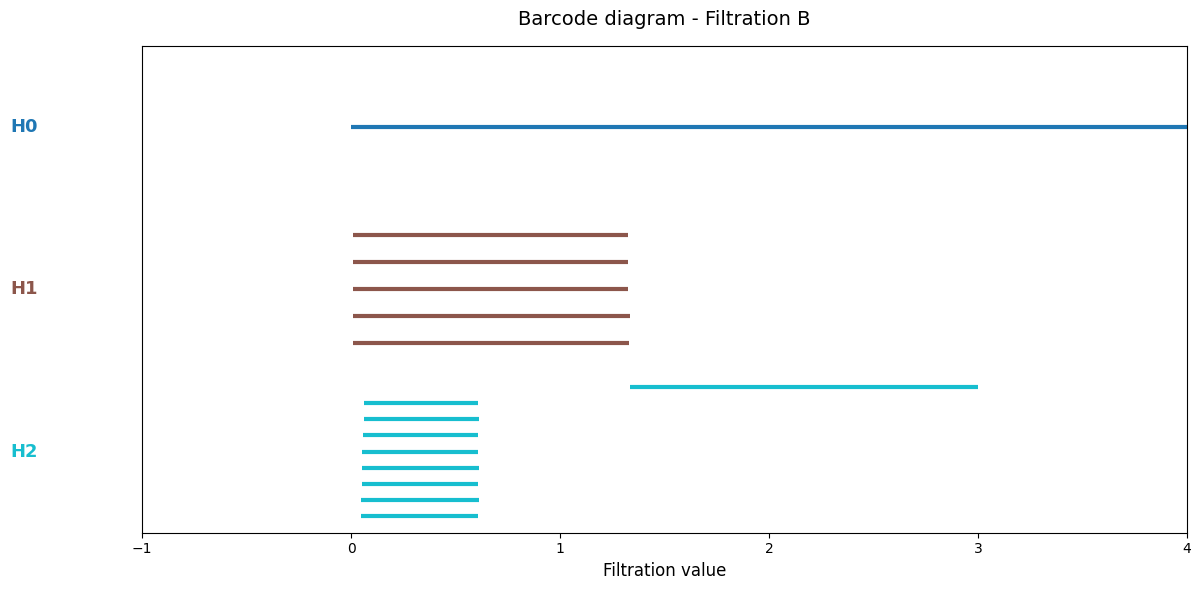

Size of filtration B: 108161
Time to process filtration B: 5.467949151992798 seconds


In [17]:
filtration_b = read_filtration("filtrations/filtration_B.txt")
duration = process_filtration(filtration_b, name="Filtration B")
print("Size of filtration B:", len(filtration_b))
print("Time to process filtration B:", duration, "seconds")

Size of filtration B: 108161
Time to process filtration B: 5.4838478565216064 seconds

Analyse de l'objet topologique sous-jacent :
- Les nombres de Betti sont les mêmes que pour la filtration A. On a donc la même analyse que pour l'objet A.
- Dans la filtration B, les sommets sont rajoutés puis les arêtes très rapidement après pour les relier (puisque toutes les barres H_0 étaient très courtes sauf la seule infinie).


### Filtration C

Boundary matrix computed.
Barcodes extracted.


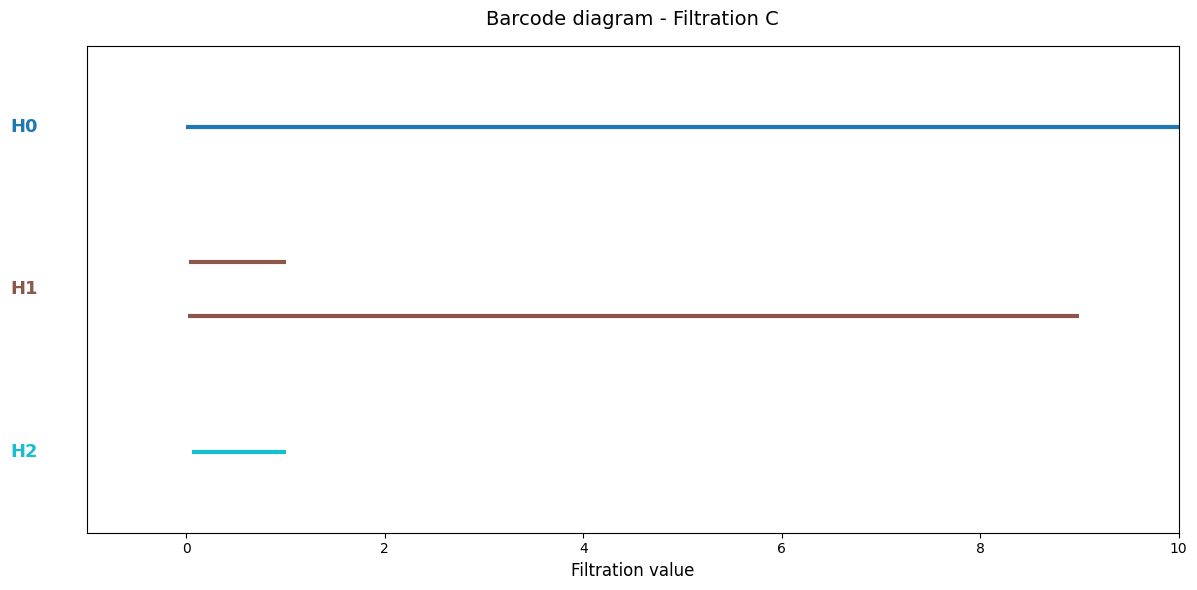

Size of filtration C: 180347
Time to process filtration C: 14.59340786933899 seconds


In [16]:
filtration_c = read_filtration("filtrations/filtration_C.txt")
duration = process_filtration(filtration_c, name="Filtration C")
print("Size of filtration C:", len(filtration_c))
print("Time to process filtration C:", duration, "seconds")

Size of filtration C: 180347
Time to process filtration C: 14.717528820037842 seconds

### Filtration D

Boundary matrix computed.
Barcodes extracted.


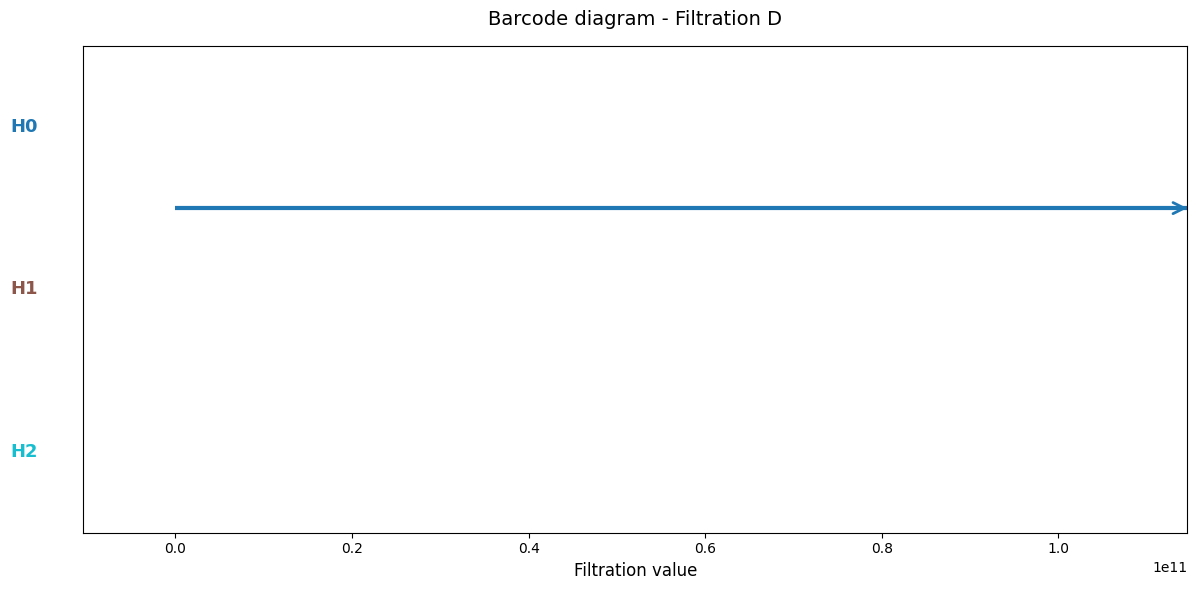

Size of filtration D: 2716431
Time to process filtration D: 586.8552062511444 seconds


In [ ]:
filtration_d = read_filtration("filtrations/filtration_D.txt")
duration = process_filtration(filtration_d, name="Filtration D")
print("Size of filtration D:", len(filtration_d))
print("Time to process filtration D:", duration, "seconds")

Size of filtration D: 2716431
Time to process filtration D: 586.8552062511444 seconds

<table>
  <thead>
    <tr>
      <th style="text-align:left;">Filtration</th>
      <th style="text-align:right;">Size</th>
      <th style="text-align:right;">Time (s)</th>
      <th style="text-align:right;">Time / Size (s / élément)</th>
    </tr>
  </thead>
  <tbody>
    <tr><td>A</td><td style="text-align:right;">428 643</td><td style="text-align:right;">108.7078</td><td style="text-align:right;">0.0002536</td></tr>
    <tr><td>B</td><td style="text-align:right;">108 161</td><td style="text-align:right;">5.4838</td><td style="text-align:right;">0.0000507</td></tr>
    <tr><td>C</td><td style="text-align:right;">180 347</td><td style="text-align:right;">14.7175</td><td style="text-align:right;">0.0000816</td></tr>
    <tr><td>D</td><td style="text-align:right;">2 716 431</td><td style="text-align:right;">444.8562</td><td style="text-align:right;">0.0001638</td></tr>
  </tbody>
</table>